In [1]:
import os
import re
import SMBcorr
import h5py
import numpy as np
import pointCollection as pc
import ipywidgets as widgets
import matplotlib.pyplot as plt
import netCDF4 as nc
import shapely.geometry as shg
%matplotlib notebook

In [4]:
P={}
with open('../masks/GrnDrainageSystems_Ekholm.txt') as fh:
    for line in fh:
        try:
            temp=np.array([float(K) for K in line.split()])
        except Exception:
            continue
        if temp[0] not in P:
            P[temp[0]]={'latitude':[], 'longitude':[]}
        P[temp[0]]['latitude']+=[temp[1]]
        P[temp[0]]['longitude']+=[temp[2]]
basins=np.array(list(P.keys()))

for key in basins:
    for k1 in ['latitude', 'longitude']:
        P[key][k1]=np.array(P[key][k1])
    P[key]=pc.data().from_dict(P[key]).get_xy(EPSG=3413)
    P[key]=shg.Polygon(zip(P[key].x, P[key].y))

In [5]:
# make a grid of basins [this takes a while!]
xx=np.array(ds['x'])
yy=np.array(ds['y'])
dx=xx[1,1]-xx[0,0]
basin_mask=np.zeros([len(basins), xx.shape[0], xx.shape[1]])

dxp=dx*(np.array([0, 1, 1, 0])-0.5)
dyp=dx*(np.array([1, 1, 0, 0])-0.5)

for count, basin in enumerate(basins):
    Pi=P[basin]
    xyp=np.array(Pi.exterior.coords)
    XR=np.array([np.min(xyp[:,0]), np.max(xyp[:,0])])+np.array([-1, 1])*dx
    YR=np.array([np.min(xyp[:,1]), np.max(xyp[:,1])])+np.array([-1, 1])*dx
    g_sub = np.flatnonzero((xx>=XR[0]) &  (xx <= XR[1]) & (yy > YR[0]) & (yy < YR[1]))
    basin_temp=np.zeros(xx.size)
    for gi in g_sub:
        temp=shg.Polygon(zip(xx.ravel()[gi]+dxp, yy.ravel()[gi]+dyp))
        basin_temp[gi]=temp.intersection(Pi).area/dx**2
    basin_mask[count,:,:]=basin_temp.reshape(xx.shape)


In [28]:
# write the mask to a file:
! rm ../masks/merra_basin_mask.nc

mds = nc.Dataset('../masks/merra_basin_mask.nc','w') 
mds.createDimension('basin', basin_mask.shape[0])
mds.createDimension('x', basin_mask.shape[1])
mds.createDimension('y', basin_mask.shape[2])
bv=mds.createVariable('basin', np.float32, ('basin',))
xv=mds.createVariable('x', np.float32, ('x',))
yv=mds.createVariable('y', np.float32, ('y',))
mv=mds.createVariable('mask', np.float32, ('basin','x','y',))
bv[:]=np.array(list(P.keys()))
xv[:]=xx[:,0].ravel()
yv[:]=yy[0,:].ravel()
mv[:,:,:] = basin_mask
mds.close()


In [2]:
thedir='/Volumes/ice1/tyler/MERRA2_hybrid/v1.1/'
thefile=thedir+'gsfc_fdm_v1_gris.nc'
os.path.isfile(thefile)

True

In [31]:
ds=nc.Dataset(thefile,'r')
print(ds)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    creation_date: 06-Aug-2020 12:52:06
    dimensions(sizes): x(441), y(281), time(2922)
    variables(dimensions): float64 x(x,y), float64 y(x,y), float64 time(time), float64 FAC(time,x,y), float64 cum_smb_anomaly(time,x,y), float64 height(time,x,y)
    groups: 



In [45]:
# read the basin mask from its file:
mds = nc.Dataset('../masks/merra_basin_mask.nc','r')
basin_mask = np.array(mds['mask'])
mds.close()

# remove cells from the mask where the data are invalid
for bi, basin in enumerate(basins):
    N0=np.sum(basin_mask[bi,:,:])
    for field in ['FAC','cum_smb_anomaly','height']:
        d_temp=np.array(ds[field][0,:,:])
        basin_mask[bi, :, :][d_temp<=-9999]=0
    N1=np.sum(basin_mask[bi,:,:])
    print([bi, N0, N1])


[0, 804.7682, 804.73627]
[1, 389.6349, 389.551]
[2, 281.64838, 281.56537]
[3, 107.069595, 107.069595]
[4, 1695.354, 1695.354]
[5, 318.36176, 317.36176]
[6, 934.59106, 934.59106]
[7, 228.8024, 228.80157]
[8, 471.66492, 471.66492]
[9, 421.02148, 421.02148]
[10, 308.59113, 308.59094]
[11, 223.42093, 223.42093]
[12, 337.91516, 337.91254]
[13, 334.2354, 334.23428]
[14, 895.6693, 895.6693]
[15, 610.9329, 610.9329]
[16, 825.15173, 825.1483]
[17, 1505.524, 1505.4995]
[18, 206.77477, 206.77332]


In [38]:
ds['cum_smb_anomaly']

<class 'netCDF4._netCDF4.Variable'>
float64 cum_smb_anomaly(time, x, y)
    _FillValue: -9999.0
    long_name: Cumulative SMB Anomaly
    units: meters of ice
    comment: The GSFC-FDMv1 cumulative SMB anomaly with a reference climate interval of 1980 through 1995.
unlimited dimensions: 
current shape = (2922, 441, 281)
filling on

In [81]:
hist={}
nt=len(ds['time'])
for bi, basin in enumerate(basins):
    hist[basin]={}
    cols=np.flatnonzero(np.any(basin_mask[bi,:,:], axis=0))[None,:]
    rows=np.flatnonzero(np.any(basin_mask[bi,:,:], axis=1))[:, None]
    ii=np.flatnonzero(basin_mask[bi,rows,cols])
    A = basin_mask[bi,rows, cols].sum()
    m_sub=basin_mask[bi,rows,cols].ravel()[ii]
    for field in ['FAC','cum_smb_anomaly','height']:
        d_temp=ds[field]
        hist[basin][field]=np.zeros(nt)
        for it in range(nt):
            hist[basin][field][it] = \
                np.sum(np.array(d_temp[it,:,:])[rows, cols].ravel()[ii]*m_sub)/A



<IPython.core.display.Javascript object>


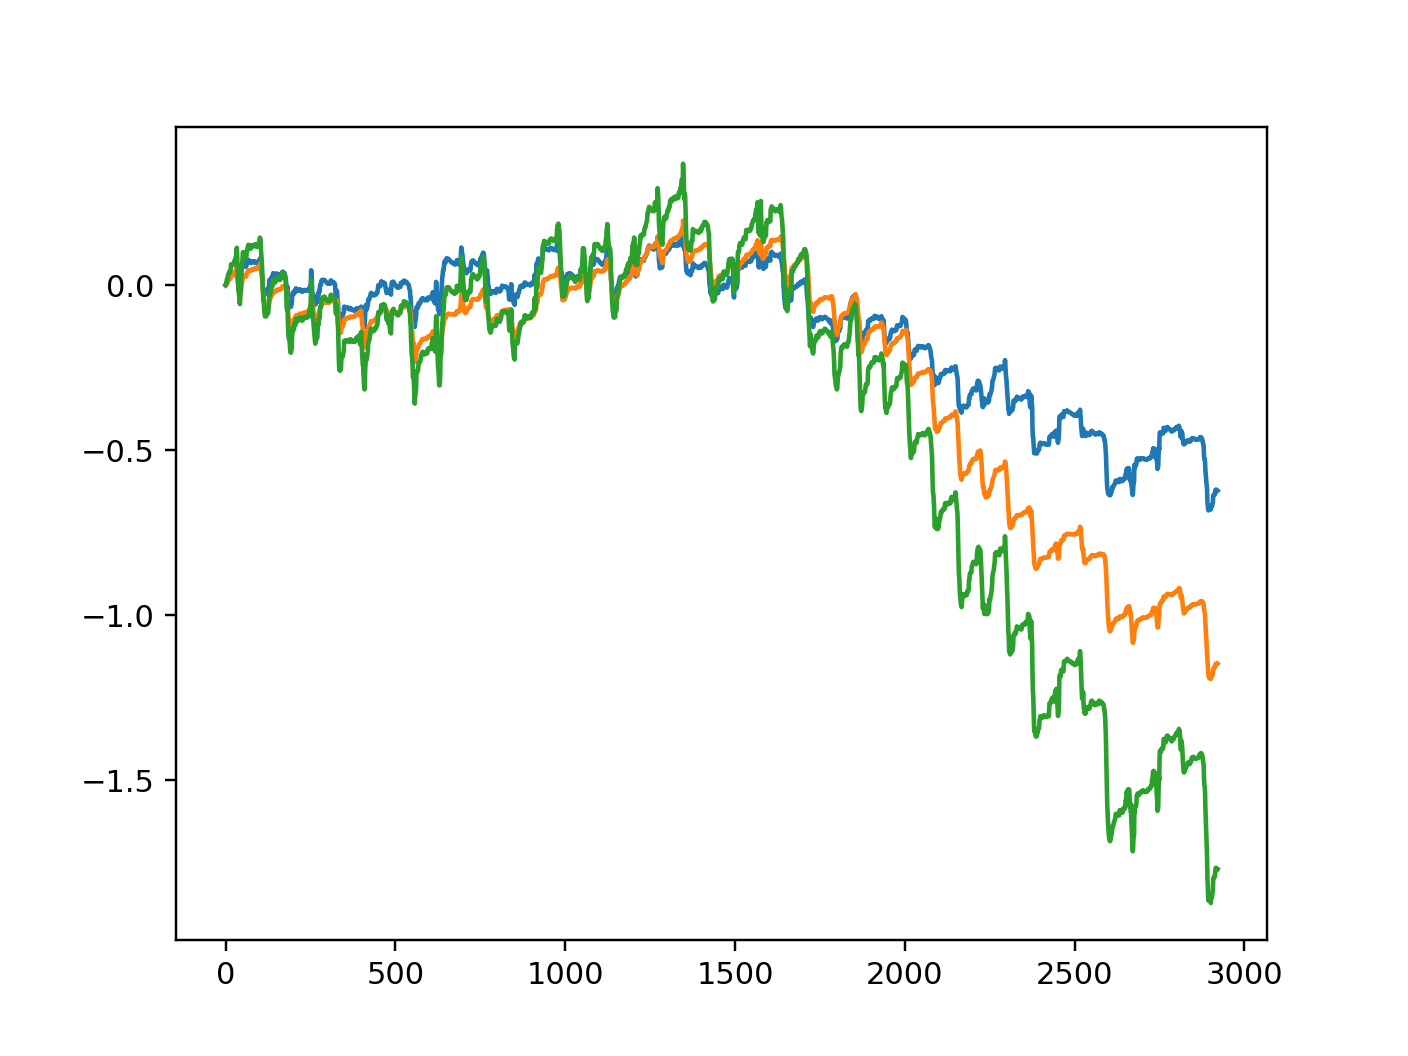

In [96]:

plt.figure(1); plt.clf(); 
plt.plot(hist[1.1]['FAC']-hist[1.1]['FAC'][0])

for field in ['cum_smb_anomaly','height']:
    plt.plot(hist[1.1][field])


In [98]:
! mkdir ../time_history/merra_hybrid_v1.1

In [111]:
# write the data to a file
! rm ../time_history/merra_hybrid_v1.1/basin_hist.nc

hds = nc.Dataset('../time_history/merra_hybrid_v1.1/basin_hist.nc','w')
hds.createDimension('basin', len(basins))
hds.createDimension('time', nt)
bv=hds.createVariable('basin', np.float32, ('basin',))
bv[:]=basins
tv=hds.createVariable('time', np.float32, ('time',))
tv[:]=np.array(ds['time'])
for varname in ['FAC','cum_smb_anomaly','height']:
    mv=hds.createVariable(varname, np.float32, ('basin', 'time'))
    for bi, basin in enumerate(basins):
        mv[bi,:] = hist[basin][varname]
hds.close()

<IPython.core.display.Javascript object>


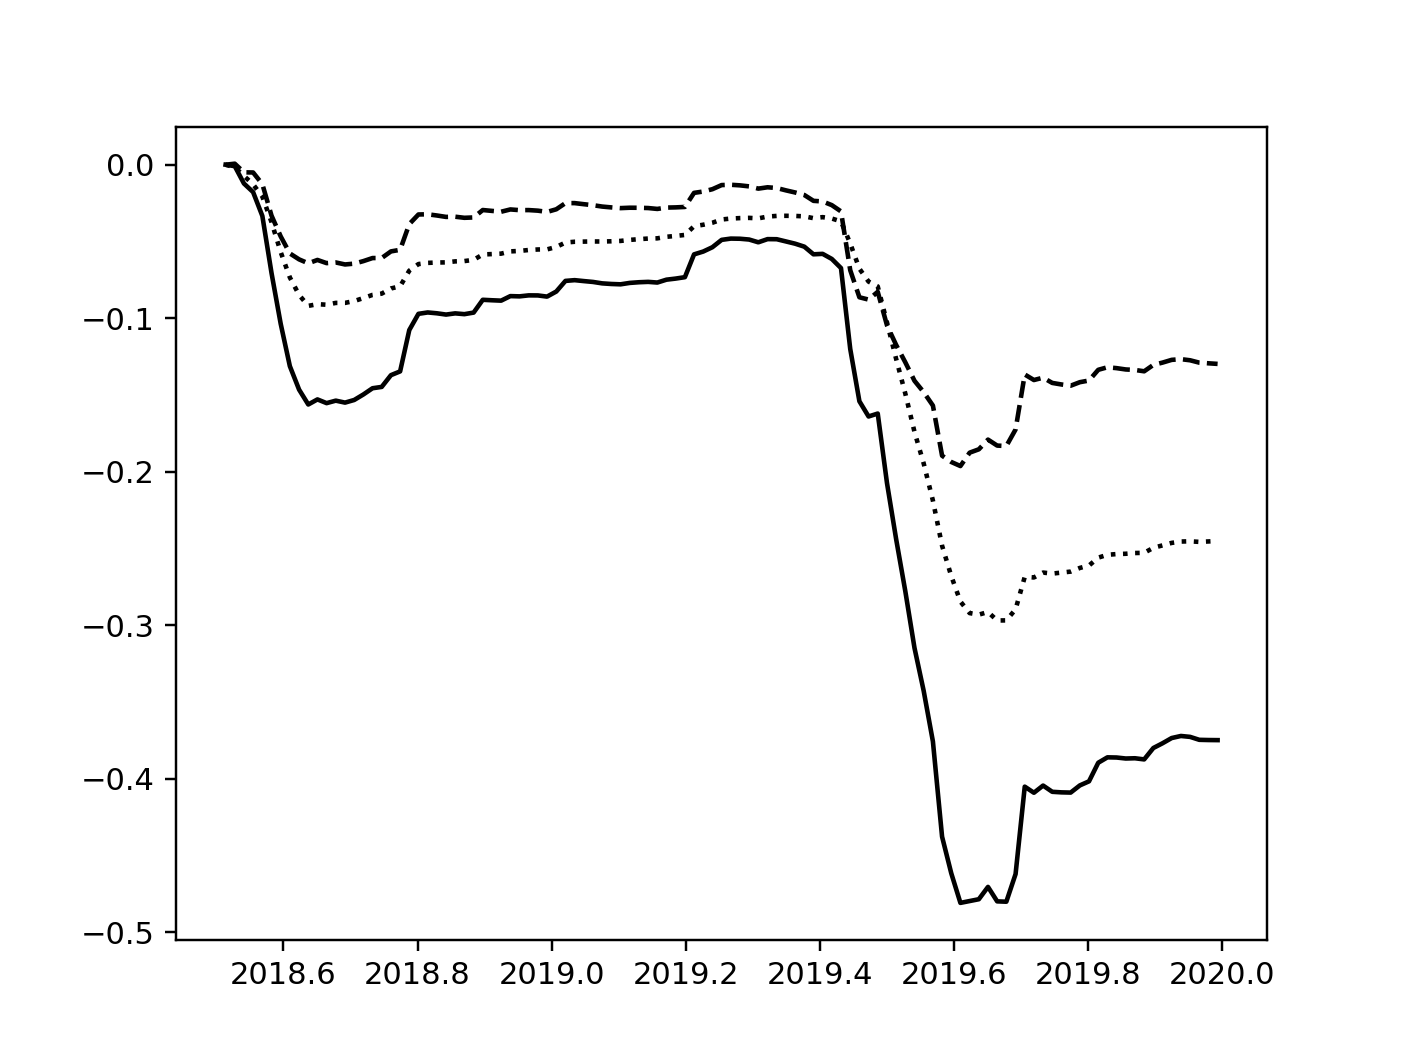

FAC
cum_smb_anomaly
height


In [138]:
me={}
me['ds'] = nc.Dataset('/home/ben/git_repos/SMBcorr/time_history/merra_hybrid_v1.1/basin_hist.nc','r')
me['components']=['FAC', 'cum_smb_anomaly','height']
me['year'] = np.array(me['ds']['time'])
component_styles=['--',':','-']
me['t_sub']= me['year']> 2018.5
me['basin'] = me['ds']['basin']
bi=np.flatnonzero(np.floor(np.array(me['basin'])) == 1)
bi=slice(bi[0], bi[-1]+1)
plt.figure(2); 
plt.clf()
for ci, component in enumerate(components):
    print(component)
    temp=np.mean(np.array(me['ds'][me['components'][ci]])[bi,:], axis=0).ravel()[me['t_sub']]
    plt.plot(me['year'][me['t_sub']], temp-temp[0], component_styles[ci],color='k')
me['ds'].close()

In [136]:
np.array(me['ds'][me['components'][ci]])[bi,:].ravel().shape

(11688,)

In [133]:
bi

array([0, 1, 2, 3])

In [122]:
np.array(me['ds'][me['components'][ci]])

array([[14.437592 , 14.4385   , 14.441203 , ..., 13.814199 , 13.814062 ,
        13.815225 ],
       [15.3241005, 15.324947 , 15.329308 , ..., 14.561924 , 14.561002 ,
        14.560329 ],
       [13.183647 , 13.185084 , 13.190275 , ..., 12.338895 , 12.338178 ,
        12.337342 ],
       ...,
       [20.043146 , 20.05596  , 20.07197  , ..., 19.654379 , 19.650936 ,
        19.655828 ],
       [19.238594 , 19.2432   , 19.256763 , ..., 19.0224   , 19.020475 ,
        19.028858 ],
       [ 9.928521 ,  9.93507  ,  9.950244 , ...,  9.654596 ,  9.657847 ,
         9.667033 ]], dtype=float32)

In [ ]:
# PURPOSE: convert time from delta seconds into Julian and year-decimal
def convert_delta_time(delta_time, gps_epoch=1198800018.0):
    # calculate gps time from delta_time
    gps_seconds = gps_epoch + delta_time
    time_leaps = SMBcorr.count_leap_seconds(gps_seconds)
    # calculate julian time
    time_julian = 2444244.5 + (gps_seconds - time_leaps)/86400.0
    # convert to calendar date with convert_julian.py
    Y,M,D,h,m,s = SMBcorr.convert_julian(time_julian,FORMAT='tuple')
    # calculate year-decimal time
    time_decimal = SMBcorr.convert_calendar_decimal(Y,M,DAY=D,HOUR=h,MINUTE=m,SECOND=s)
    # return both the Julian and year-decimal formatted dates
    return dict(julian=time_julian, decimal=time_decimal)

In [ ]:
delta_time=np.arange(0, 2*365.25*24*3600, 3600*24)

tdec = convert_delta_time(delta_time)['decimal'][:,np.newaxis]

x0=-27000+np.arange(-6.e4, 8.e4, 2.e4)[np.newaxis,:]
y0=-2490500+np.zeros_like(x0)

x=x0+np.zeros_like(tdec)
y=y0+np.zeros_like(tdec)
t=tdec+np.zeros_like(x0)

height = SMBcorr.interpolate_merra_hybrid(thedir, 'EPSG:3413',
                'gris', t.ravel(), x.ravel(), y.ravel(),
                VERSION='v1', VARIABLE='height',
                SIGMA=1.5, FILL_VALUE=np.nan).reshape(x.shape)


In [ ]:
plt.figure(); 
for col in range(x.shape[1]):
    plt.plot(tdec, height[:,col], label=f'x0={x0[0][col]/1000}km')
plt.legend()
plt.title(f'y={y0[0,0]/1000}km')

In [ ]:

x0[0][col]

In [ ]:
x.shape

In [ ]:

DS=nc.Dataset('/Volumes/ice2/ben/MAR/MAR_SMBavg_10km_1980-1996.nc')
#xx=np.array(DS['x'])
#yy=np.array(DS['y'])

print(DS)



In [ ]:
plt.figure(); plt.imshow(DS['SMB'], origin='lower')